In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px

# Create the dataset

The dataset should have values for each day for at least 2 years. The promotions generally run during the months of Feb, March and then Nov, Dec. The promotions are generally offered as a percent of the price off. For example, 15% off the price of $3.99

## Class and methods for generating the dataframe

In [2]:
class Generate_Dataset:

    """
    Class for generating and visualizing dataset
    Takes the following arguments to initialize

    Parameters
    -------------
    start_date : datetime
        start date for the dataset
    end_date : datetime
        end date of the dataset
    stores : dict
        A dictionary containing the store names as keys and their unit sold intercepts as values
    """

    def __init__(self, start_date:str, end_date:str, stores:dict = None) -> None:
        self.start_date = start_date
        self.end_date = end_date
        self.store_weights = stores
        self.date_array = pd.date_range(start=start_date, end=end_date, freq='D')
        

    def generate_df(self, wt_price:float, wt_promo:float):
        """
        Function to generate the dataframe

        Parameters
        -------------
        start_date : datetime
            start date for the dataset
        end_date : datetime
            end date of the dataset
        stores : dict
            A dictionary containing the store names as keys and their unit sold intercepts as values

        Values
        -------------
        returns a dataframe with the columns date, price, promo_amount, units_sold.
        """

        ## Price
        price = np.where(self.date_array.month<=6, 3, 6) * np.random.normal(loc = 1, scale = 0.05, size = self.date_array.shape[0])

        # Promo indicator and promo
        promo_indicator = np.isin(self.date_array.month, [2,3,11,12])
        promo_amount = np.where(self.date_array.month <=6, 0.2*price, 0.3*price)

        ## Total units sold
        #np.zeros(shape = self.date_array.shape, dtype=np.float32)
        total_units_sold = 2 + (wt_price * np.power(price, 2)) + wt_promo * np.log(1+promo_amount) * promo_indicator
        total_units_sold = np.max(np.array([total_units_sold, np.zeros(shape = self.date_array.shape)]), axis = 0)  ## Make sure that the untis sold is never negative

        pdf_ = pd.DataFrame({"date":self.date_array,
                            "price":price,
                            "promo_amount":promo_amount * promo_indicator,
                            "units_sold":total_units_sold})

        self.data = pdf_

        return self.data

    def viz_ts_data(self):
        """
        Visualizes the generated data
        """
        df_melted = self.data.melt(id_vars="date")

        fig = px.line(data_frame=df_melted, x = 'date', y = 'value', color='variable')
        fig.show()  


In [3]:
SALES = Generate_Dataset(start_date="2021-01-01", end_date="2021-12-31")

In [4]:
weights = {"wt_price":-0.008, "wt_promo":0.3}
df_sales = SALES.generate_df(**weights)

In [5]:
df_sales.head()

,date,price,promo_amount,units_sold
0,2021-01-01,3.055001,0.0,1.925336
1,2021-01-02,2.931119,0.0,1.931268
2,2021-01-03,3.010123,0.0,1.927513
3,2021-01-04,2.896530,0.0,1.932881
4,2021-01-05,2.894292,0.0,1.932985


In [6]:
SALES.viz_ts_data()

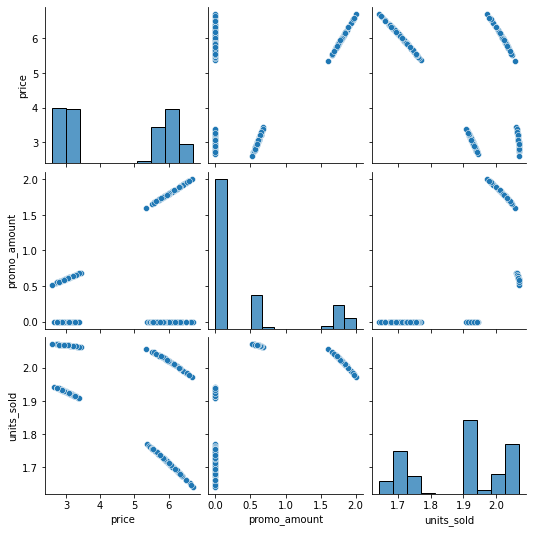

In [7]:
sns.pairplot(data = df_sales)

# Models to estimate the causal effect of promo and prices on units sold

In [8]:
df_sales.dtypes

date            datetime64[ns]
price                  float64
promo_amount           float64
units_sold             float64
dtype: object

In [9]:
def plot_predictions(model, dataset, y = 'units_sold'):
    
    """
    Parameters
    --------------
    model: statemodel
        A model whose predict function would be called on the dataset
    dataset: pd.DataFrame
        A dataset on which the model's predict method would be called
    
    Values
    --------------
    plots a plotly plot for comparing the prediction and the actual
    """

    df_predicted = (dataset
    .assign(predicted = model.predict(dataset))
    .loc[:, ['date', y, 'predicted']]
    .melt(id_vars = 'date')
    )

    fig1 =  px.line(data_frame = df_predicted, x = 'date', y = 'value', color = 'variable')

    fig1.show()

## Simple model

A model without the correct specification of the transformations

In [10]:
model1 = smf.ols("units_sold ~ price + promo_amount", data = df_sales).fit()

In [11]:
print(f"model estimates : \n{model1.params[-2:]}")
print(f"original_estimates = {weights}")

model estimates : 
price          -0.077668
promo_amount    0.177648
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


**Estimates are way off**

In [12]:
plot_predictions(model1, df_sales)

## Model with exact functional form

This should be able to recover the exact estimates. However, in practicality, this cannot be implemented as we would never know the exact form.

In [13]:
df_sales = (df_sales
    .assign(log_one_plus_promo = lambda df: np.log(1+df.promo_amount))
    .assign(squared_price = lambda df: np.power(df.price, 2))
)

In [14]:
model2 = smf.ols("units_sold ~ squared_price + log_one_plus_promo", data = df_sales).fit()

In [15]:
print(f"model estimates : \n{model2.params[-2:]}")
print(f"original_estimates = {weights}")

model estimates : 
squared_price        -0.008
log_one_plus_promo    0.300
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


In [16]:
plot_predictions(model2, df_sales)

**This recovers the correct estimates**

<AxesSubplot:ylabel='Density'>

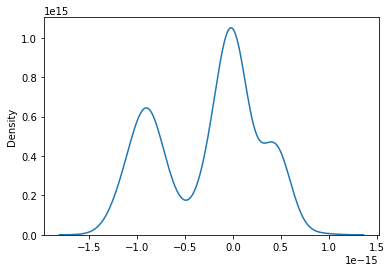

In [34]:
## Residuals analysis
sns.kdeplot(model2.resid)

**Residuals seem really bad**

The residuals are abhorent! But, the model is an exact fit. This happens when the model has non linear terms

## Model with interaction between promo_indicator and promo_amount

In [17]:
df_sales = (df_sales
    .assign(promo_ind = lambda df: np.where(df.promo_amount==0, 0, 1))
    .assign(log_promo = lambda df: np.log(df.promo_amount+ 0.00001))
    .assign(log_three_plus_promo = lambda df: np.log(3+df.promo_amount))
    .assign(log_sales_units = lambda df: np.log(df.units_sold))
)
df_sales.head()

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
0,2021-01-01,3.055001,0.0,1.925336,0.0,9.333034,0,-11.512925,1.098612,0.655100
1,2021-01-02,2.931119,0.0,1.931268,0.0,8.591459,0,-11.512925,1.098612,0.658177
2,2021-01-03,3.010123,0.0,1.927513,0.0,9.060842,0,-11.512925,1.098612,0.656231
3,2021-01-04,2.896530,0.0,1.932881,0.0,8.389885,0,-11.512925,1.098612,0.659012
4,2021-01-05,2.894292,0.0,1.932985,0.0,8.376925,0,-11.512925,1.098612,0.659065


In [97]:
model3 = smf.ols("units_sold ~ price + squared_price + log_promo * promo_amount", data = df_sales).fit()

In [98]:
print(f"model estimates : \n{model3.params}")
print(f"original_estimates = {weights}")

model estimates : 
Intercept                 1.982086
price                     0.000003
squared_price            -0.008000
log_promo                -0.001555
promo_amount              0.225650
log_promo:promo_amount   -0.074149
dtype: float64
original_estimates = {'wt_price': -0.008, 'wt_promo': 0.3}


In [99]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             units_sold   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.900e+09
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:23:25   Log-Likelihood:                 3600.0
No. Observations:                 365   AIC:                            -7188.
Df Residuals:                     359   BIC:                            -7165.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.9821   4.38e-05   4.53e+04      0.000       1.982       1.982
price                   3.078e-06   1.13e-05      0.272      0.786   -1.92e-05    2.54e-05
squared_price             -0.0080   1.24e-06  -6429.435      0.000      -0.008      -0.008
log_promo                 -0.0016   4.72e-06   -329.712      0.000      -0.002      -0.002
promo_amount               0.2256   6.09e-05   3707.419      0.000       0.226       0.226
log_promo:promo_amount    -0.0741   4.94e-05  -1501.218      0.000      -0.074      -0.074
==============================================================================
Omnibus:                      158.795   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1168.401
Skew:                           1.658   Prob(JB):                    1.93e-254
Kurtosis:                      11.113   Cond. No.                     3.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='log_promo', ylabel='Count'>

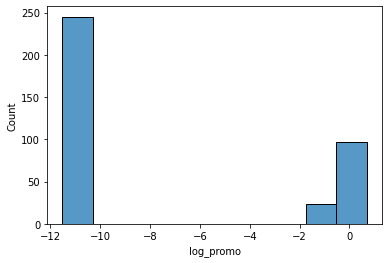

In [72]:
sns.histplot(df_sales, x = "log_promo")

In [73]:
plot_predictions(model3, df_sales, y = 'units_sold')

<AxesSubplot:ylabel='Density'>

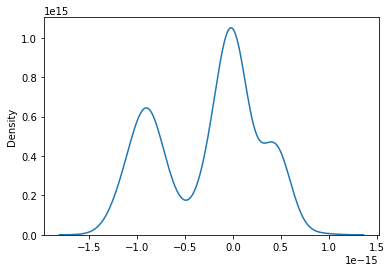

In [74]:
sns.kdeplot(model2.resid)

## Test changes in promo prices

In [101]:
df_sales.iloc[30:40, :]

,date,price,promo_amount,units_sold,log_one_plus_promo,squared_price,promo_ind,log_promo,log_three_plus_promo,log_sales_units
30,2021-01-31,2.860573,0.000000,1.934537,0.000000,8.182877,0,-11.512925,1.098612,0.659868
31,2021-02-01,2.826577,0.565315,2.070510,0.448087,7.989539,1,-0.570354,1.271253,0.727795
32,2021-02-02,2.906596,0.581319,2.069891,0.458259,8.448300,1,-0.542438,1.275731,0.727496
33,2021-02-03,2.974682,0.594936,2.069260,0.466834,8.848733,1,-0.519284,1.279526,0.727191
34,2021-02-04,3.229284,0.645857,2.066052,0.498261,10.428275,1,-0.437162,1.293591,0.725640
35,2021-02-05,2.849325,0.569865,2.070348,0.450990,8.118651,1,-0.562338,1.272528,0.727717
36,2021-02-06,2.976975,0.595395,2.069237,0.467121,8.862383,1,-0.518513,1.279654,0.727180
37,2021-02-07,2.835900,0.567180,2.070445,0.449278,8.042326,1,-0.567061,1.271775,0.727763
38,2021-02-08,3.107675,0.621535,2.067751,0.483373,9.657642,1,-0.475547,1.286898,0.726461
39,2021-02-09,2.941684,0.588337,2.069578,0.462687,8.653505,1,-0.530439,1.277689,0.727345


In [102]:
0.64/3.22

0.19875776397515527

In [151]:
def gen_simulated_df(price:float, model):
    df_simulated = pd.DataFrame({"price":price,
                            "promo_amount": np.concatenate([np.repeat(0.0, 33), np.repeat(0.2*price, 33), np.repeat(0.3*price, 33)])})

    df_simulated = (df_simulated
        .assign(log_promo = lambda df: np.log(df.promo_amount+0.00001))
        .assign(squared_price = lambda df: np.power(df.price, 2))
    )

    df_simulated = (df_simulated
    .assign(predicted = model.predict(df_simulated))
    )

    return df_simulated

In [157]:
df_simPrice3 = gen_simulated_df(price = 3.0, model = model3)
df_simPrice6 = gen_simulated_df(price = 6.0, model = model3)

df_sim = pd.concat([df_simPrice3, df_simPrice6], axis = 0)

In [158]:
px.line(data_frame = df_sim, x = 'log_promo', y = 'predicted', color = 'price')

In [159]:
px.line(data_frame = df_sim, x = 'promo_amount', y = 'predicted', color = 'price')

In [160]:
px.line(data_frame = df_sales.assign(price = lambda df: df.query("price >= 2.95 and price <= 3.05").price.round()), x = 'promo_amount', y = 'units_sold', color = 'price')